In [4]:
def coef2curve(x_eval, grid, coef, k, device="cpu"):
        if coef.dtype != x_eval.dtype:
            coef = coef.to(x_eval.dtype)
        y_eval = torch.einsum('ij,ijk->ik', coef, B_batch(x_eval, grid, k, device=device))
        return y_eval

def curve2coef(x_eval, y_eval, grid, k, device="cpu"):
        mat = B_batch(x_eval, grid, k, device=device).permute(0, 2, 1)
        coef = torch.linalg.lstsq(mat.to(device), y_eval.unsqueeze(dim=2).to(device), driver='gelsy' if device == 'cpu' else 'gels').solution[:, :, 0]
        return coef.to(device)

def B_batch(x, grid, k=0, extend=True, device='cpu'):
        def extend_grid(grid, k_extend=0):
            h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)
            for i in range(k_extend):
                grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
                grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
            grid = grid.to(device)
            return grid

        if extend:
            grid = extend_grid(grid, k_extend=k)

        grid = grid.unsqueeze(dim=2).to(device)
        x = x.unsqueeze(dim=1).to(device)

        if k == 0:
            value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
        else:
            B_km1 = B_batch(x[:, 0], grid=grid[:, :, 0], k=k - 1, extend=False, device=device)
            value = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * B_km1[:, :-1] + (grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * B_km1[:, 1:]

        return value

In [5]:
import torch
import torch.nn as nn
import numpy as np

class KANLayer(nn.Module):
    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.1, scale_base=1.0, scale_sp=1.0, base_fun=nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, device='cpu'):
        super(KANLayer, self).__init__()

        # Initialize dimensions
        self.size = size = out_dim * in_dim
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.num = num
        self.k = k
        self.device = device

        # Create grid with shape (size, num+1)
        self.grid = torch.einsum('i,j->ij', torch.ones(size, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device))
        self.grid = nn.Parameter(self.grid, requires_grad=False)

        # Add noise to the grid
        noises = (torch.rand(size, self.grid.shape[1], device=device) - 0.5) * noise_scale / num

        # Create coefficient tensor
        self.coef = nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))

        # Scale parameters
        if isinstance(scale_base, float):
            self.scale_base = nn.Parameter(torch.ones(size, device=device) * scale_base, requires_grad=sb_trainable)
        else:
            self.scale_base = nn.Parameter(torch.FloatTensor(scale_base).to(device), requires_grad=sb_trainable)

        self.scale_sp = nn.Parameter(torch.ones(size, device=device) * scale_sp, requires_grad=sp_trainable)

        # Base function
        self.base_fun = base_fun

        # Additional parameters
        self.mask = nn.Parameter(torch.ones(size, device=device), requires_grad=False)
        self.grid_eps = grid_eps
        self.weight_sharing = torch.arange(size, device=device)
        self.lock_counter = 0
        self.lock_id = torch.zeros(size, device=device)

    def forward(self, x):
        batch = x.shape[0]
        x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, device=self.device)).reshape(batch, self.size).permute(1, 0)
        preacts = x.permute(1, 0).clone().reshape(batch, self.out_dim, self.in_dim)
        base = self.base_fun(x).permute(1, 0)
        y = coef2curve(x_eval=x, grid=self.grid[self.weight_sharing], coef=self.coef[self.weight_sharing], k=self.k, device=self.device)
        y = y.permute(1, 0)
        postspline = y.clone().reshape(batch, self.out_dim, self.in_dim)
        y = self.scale_base.unsqueeze(dim=0) * base + self.scale_sp.unsqueeze(dim=0) * y
        y = self.mask[None, :] * y
        postacts = y.clone().reshape(batch, self.out_dim, self.in_dim)
        y = torch.sum(y.reshape(batch, self.out_dim, self.in_dim), dim=2)
        return y, preacts, postacts, postspline

    def update_grid_from_samples(self, x):
        batch = x.shape[0]
        x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, device=self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = torch.sort(x, dim=1)[0]
        y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
        num_interval = self.grid.shape[1] - 1
        ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
        grid_adaptive = x_pos[:, ids]
        margin = 0.01
        grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
        self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

    def initialize_grid_from_parent(self, parent, x):
        batch = x.shape[0]
        x_eval = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, device=self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = parent.grid
        sp2 = KANLayer(in_dim=1, out_dim=self.size, k=1, num=x_pos.shape[1] - 1, scale_base=0., device=self.device)
        sp2.coef.data = curve2coef(sp2.grid, x_pos, sp2.grid, k=1, device=self.device)
        y_eval = coef2curve(x_eval, parent.grid, parent.coef, parent.k, device=self.device)
        percentile = torch.linspace(-1, 1, self.num + 1).to(self.device)
        self.grid.data = sp2(percentile.unsqueeze(dim=1))[0].permute(1, 0)
        self.coef.data = curve2coef(x_eval, y_eval, self.grid, self.k, self.device)

# Example usage:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = KANLayer(device=device)


In [9]:
import torch
import torch.nn as nn

class KAN(nn.Module):
    def __init__(self, layer_dims, k=3, noise_scale=0.1, scale_base=1.0, scale_sp=1.0, base_fun=nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, device='cpu'):
        super(KAN, self).__init__()
        # Create layers based on the provided dimensions
        self.layers = nn.ModuleList([
            KANLayer(
                in_dim=layer_dims[i],
                out_dim=layer_dims[i + 1],
                num=5,
                k=k,
                noise_scale=noise_scale,
                scale_base=scale_base,
                scale_sp=scale_sp,
                base_fun=base_fun,
                grid_eps=grid_eps,
                grid_range=grid_range,
                sp_trainable=sp_trainable,
                sb_trainable=sb_trainable,
                device=device
            ) for i in range(len(layer_dims) - 1)
        ])

    def update_grids(self, x):
        # Update the grid of each layer with samples from x
        for kan_layer in self.layers:
            kan_layer.update_grid_from_samples(x)

    def initialize_grids(self, parent, x):
        # Initialize the grid of each layer from a parent model
        for l, layer in enumerate(self.layers):
            layer.initialize_grid_from_parent(parent.layers[l], x)

    def forward(self, x):
        # Store intermediate activations
        preacts, postacts, postsplines = [], [], []
        for layer in self.layers:
            x, preact, postact, postspline = layer(x)
            preacts.append(preact)
            postacts.append(postact)
            postsplines.append(postspline)
        return x, preacts, postacts, postsplines


Epoch [100/1000], Loss: 0.4733, Test Accuracy: 0.7333
Epoch [200/1000], Loss: 0.2081, Test Accuracy: 0.9000
Epoch [300/1000], Loss: 0.1105, Test Accuracy: 0.9333
Epoch [400/1000], Loss: 0.0525, Test Accuracy: 0.9667
Epoch [500/1000], Loss: 0.0217, Test Accuracy: 0.9667
Epoch [600/1000], Loss: 0.0119, Test Accuracy: 0.9667
Epoch [700/1000], Loss: 0.0076, Test Accuracy: 0.9667
Epoch [800/1000], Loss: 0.0054, Test Accuracy: 0.9667
Epoch [900/1000], Loss: 0.0040, Test Accuracy: 0.9667
Epoch [1000/1000], Loss: 0.0031, Test Accuracy: 0.9667


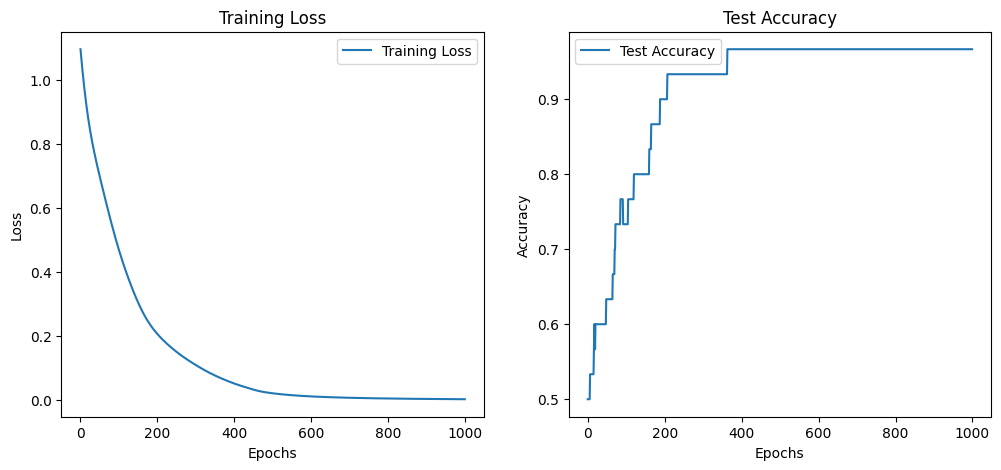

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the KAN model (assumed to be imported)
# from kan import KAN

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define model parameters
layer_dims = [4, 10, 3]  # Input dimension is 4, output dimension is 3 (number of classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the KAN model
model = KAN(layer_dims).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 1000
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs, _, _, _ = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs, _, _, _ = model(X_test.to(device))
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
        test_accuracies.append(accuracy)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

# Plot the training loss and test accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()


Epoch [1/50], Loss: 1.0430, Test Accuracy: 0.6667
Epoch [2/50], Loss: 1.0351, Test Accuracy: 0.7222
Epoch [3/50], Loss: 0.9919, Test Accuracy: 0.6667
Epoch [4/50], Loss: 0.9857, Test Accuracy: 0.6944
Epoch [5/50], Loss: 0.9554, Test Accuracy: 0.6667
Epoch [6/50], Loss: 0.9022, Test Accuracy: 0.6944
Epoch [7/50], Loss: 0.8765, Test Accuracy: 0.6944
Epoch [8/50], Loss: 0.8634, Test Accuracy: 0.6944
Epoch [9/50], Loss: 0.8638, Test Accuracy: 0.6944
Epoch [10/50], Loss: 0.9032, Test Accuracy: 0.6944
Epoch [11/50], Loss: 0.8657, Test Accuracy: 0.6944
Epoch [12/50], Loss: 0.8882, Test Accuracy: 0.6944
Epoch [13/50], Loss: 0.8816, Test Accuracy: 0.6944
Epoch [14/50], Loss: 0.8485, Test Accuracy: 0.6944
Epoch [15/50], Loss: 0.8567, Test Accuracy: 0.6944
Epoch [16/50], Loss: 0.8622, Test Accuracy: 0.6944
Epoch [17/50], Loss: 0.8184, Test Accuracy: 0.6944
Epoch [18/50], Loss: 0.8225, Test Accuracy: 0.6944
Epoch [19/50], Loss: 0.8341, Test Accuracy: 0.6944
Epoch [20/50], Loss: 0.8428, Test Accura

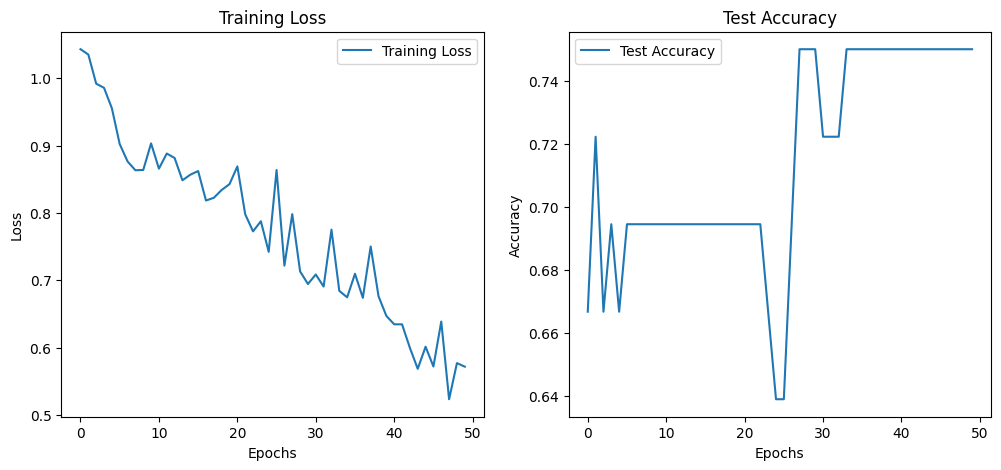

In [14]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the Wine dataset from Scikit-Learn
wine = load_wine()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
input_dim = X_train.shape[1]
output_dim = len(wine.target_names)
layer_dims = [input_dim, 64, output_dim]  # Example layer dimensions

model = KAN(layer_dims)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, _, _, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _, _, _ = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot the training loss and test accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()